In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim, Tensor
import torch.nn.functional as F
import scipy.sparse as sp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.datasets import AmazonBook, MovieLens
from torch_geometric.transforms import Compose, ToDevice, ToUndirected
from torch_geometric.data import Data
from torch_geometric.typing import Adj
from torch_sparse import SparseTensor, matmul
from torch_geometric.utils import train_test_split_edges

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


Using device cuda.


In [2]:
movie_path = './data/MovieLens/raw/ml-latest-small/movies.csv'
rating_path = './data/MovieLens/raw/ml-latest-small/ratings.csv'

In [3]:
def load_node_csv(path, index_col):
    """Loads csv containing node information
    Args:
        path (str): path to csv file
        index_col (str): column name of index column
    Returns:
        dict: mapping of csv row to node id
    """
    df = pd.read_csv(path, index_col=index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    return mapping
user_mapping = load_node_csv(rating_path, index_col='userId')
movie_mapping = load_node_csv(movie_path, index_col='movieId')

In [4]:
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping, link_index_col, rating_threshold=4):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """
    df = pd.read_csv(path)
    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold


    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])

    return torch.tensor(edge_index)


edge_index = load_edge_csv(
    rating_path,
    src_index_col='userId',
    src_mapping=user_mapping,
    dst_index_col='movieId',
    dst_mapping=movie_mapping,
    link_index_col='rating',
    rating_threshold=4,
)

In [5]:
num_users, num_movies = len(user_mapping), len(movie_mapping)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices].to(device)
val_edge_index = edge_index[:, val_indices].to(device)
test_edge_index = edge_index[:, test_indices].to(device)

In [6]:
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies)).to(device)
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies)).to(device)
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies)).to(device)

In [7]:
def sample_mini_batch(batch_size, edge_index):
    # returns a tuple of 3 tensors. Tensor 1 -> user, Tensor 2 -> positive interactions, Tensor3-> Neg interactions
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

In [26]:
from torch_geometric.utils import degree

# defines ngcf model
class NgcfLayer(MessagePassing):
  def __init__(self, emb_dim, bias=False, **kwargs):
    super(NgcfLayer, self).__init__(aggr='add', **kwargs)

    self.W1 = nn.Linear(emb_dim, emb_dim, bias=bias)
    self.W2 = nn.Linear(emb_dim, emb_dim, bias=bias)

    self.init_parameters()

  def init_parameters(self):
    nn.init.xavier_uniform_(self.W1.weight)
    nn.init.xavier_uniform_(self.W2.weight)

  def forward(self, x, edge_index):
    # Compute normalization
    from_ = edge_index.storage.col()
    to_ = edge_index.storage.row()
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    out = self.propagate(torch.stack([to_, from_], dim=0).to(device), x=x, norm=norm)

    return F.leaky_relu(out)

  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.W1(x_j) + self.W2(x_j * x_i))

  def update(self, out, x, norm):
      return F.leaky_relu(self.W1(x) + out)

class NGCF(MessagePassing):
    def __init__(self, num_users, num_items, embedding_dim=64, K=3):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K

        self.emb = nn.Embedding(num_users + num_items, embedding_dim)

        self.layers = nn.ModuleList()

        for _ in range(K):
            self.layers.append(NgcfLayer(embedding_dim))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.emb.weight)

        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, edge_index):
        emb_0 = self.emb.weight
        x = emb_0
        for layer in self.layers:
            x = layer(x, edge_index)

        users_emb_final, items_emb_final = torch.split(
            x, [self.num_users, self.num_items])

        return users_emb_final, self.emb.weight[:self.num_users, :], items_emb_final, self.emb.weight[self.num_users:, :]

model = NGCF(num_users, num_movies)


In [9]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

In [10]:
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [11]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [12]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [13]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.emb.weight[:model.num_users, :]
    item_embedding = model.emb.weight[model.num_users:, :]

    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_positive_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        rating[exclude_users, exclude_items] = -(1 << 10)

    _, top_K_items = torch.topk(rating, k=k)

    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [14]:
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

In [32]:
# define contants
ITERATIONS = 5000
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
LAMBDA = 1e-6


In [38]:
experiments = {
    "batch_1024": {
        "batch_size": 1024,
        "LR": 1e-3,
        "K": 10,
        "name": "batch_1024",
    },
    "batch_512": {
        "batch_size": 512,
        "LR": 1e-3,
        "K": 10,
        "name": "batch_512",
    },
    "batch_2048": {
        "batch_size": 2048,
        "LR": 1e-3,
        "K": 10,
        "name": "batch_2048",
    },
    "LR_1e-2": {
        "batch_size": 1024,
        "LR": 1e-2,
        "K": 10,
        "name": "LR_1e-2",
    },
    "LR_1e-3": {
        "batch_size": 1024,
        "LR": 1e-3,
        "K": 10,
        "name": "LR_1e-3",
    },
    "LR_1e-4": {
        "batch_size": 1024,
        "LR": 1e-4,
        "K": 10,
        "name": "LR_1e-4",
    },
    "K_10": {
        "batch_size": 1024,
        "LR": 1e-3,
        "K": 10,
        "name": "K_10",
    },
    "K_50": {
        "batch_size": 1024,
        "LR": 1e-3,
        "K": 50,
        "name": "K_50",
    },
    "K_100": {
        "batch_size": 1024,
        "LR": 1e-3,
        "K": 100,
        "name": "K_100",
    }
}

In [44]:
import logging

logging.basicConfig(filename="exp_log.log", level=logging.INFO, format="%(asctime)s %(message)s")

def experiment_logger(message):
    logging.info(message)
    print(message)

In [45]:
def train(experiment, optimizer, scheduler):
    # training loop
    train_losses = []
    val_losses = []

    for iter in range(ITERATIONS):
        # forward propagation
        users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
            train_sparse_edge_index)

        # mini batching
        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
            experiment["batch_size"], train_edge_index)
        user_indices, pos_item_indices, neg_item_indices = user_indices.to(
            device), pos_item_indices.to(device), neg_item_indices.to(device)
        users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
        pos_items_emb_final, pos_items_emb_0 = items_emb_final[
            pos_item_indices], items_emb_0[pos_item_indices]
        neg_items_emb_final, neg_items_emb_0 = items_emb_final[
            neg_item_indices], items_emb_0[neg_item_indices]

        # loss computation
        train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                              pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if iter % ITERS_PER_EVAL == 0 or iter == ITERATIONS - 1:
            model.eval()
            val_loss, recall, precision, ndcg = evaluation(
                model, val_edge_index, val_sparse_edge_index, [train_edge_index], experiment["K"], LAMBDA)
            experiment_logger(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
            train_losses.append(train_loss.item())
            val_losses.append(val_loss)
            model.train()

        if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
            scheduler.step()

    return train_losses, val_losses

In [46]:
def draw_graph(experiment, train_losses, val_losses):
    iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
    plt.plot(iters, train_losses, label='train')
    plt.plot(iters, val_losses, label='validation')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('training and validation loss curves')
    plt.legend()
    plt.savefig("./img/exp" + experiment["name"]+ ".png")
    plt.show()

Using device cuda.
Experiment setup: {'batch_size': 1024, 'LR': 0.001, 'K': 10, 'name': 'batch_1024'}
[Iteration 0/5000] train_loss: -1.11284, val_loss: -0.50504, val_recall@10: 0.00078, val_precision@10: 0.0009, val_ndcg@10: 0.00101
[Iteration 200/5000] train_loss: -42690150400.0, val_loss: -20600145920.0, val_recall@10: 0.00136, val_precision@10: 0.00253, val_ndcg@10: 0.00252
[Iteration 400/5000] train_loss: -2.1894225004068864e+16, val_loss: -3.28577346174976e+16, val_recall@10: 0.00622, val_precision@10: 0.00723, val_ndcg@10: 0.0078
[Iteration 600/5000] train_loss: -3.235066498204398e+20, val_loss: -1.210268424713504e+20, val_recall@10: 0.01345, val_precision@10: 0.01193, val_ndcg@10: 0.01393
[Iteration 800/5000] train_loss: -4.443736430043599e+22, val_loss: -7.503946112820715e+21, val_recall@10: 0.0157, val_precision@10: 0.01356, val_ndcg@10: 0.01626
[Iteration 1000/5000] train_loss: -3.4504425372491044e+22, val_loss: -1.2947926615783748e+22, val_recall@10: 0.01783, val_precision@

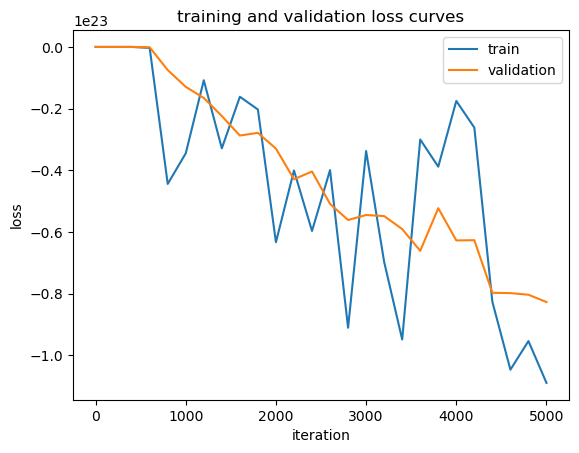

Experiment batch_1024: best train loss -1.0897496927777061e+23; best val loss -1.0897496927777061e+23; last train loss -1.0897496927777061e+23; last val loss -1.0897496927777061e+23
Experiment setup: {'batch_size': 512, 'LR': 0.001, 'K': 10, 'name': 'batch_512'}
[Iteration 0/5000] train_loss: -1.45921, val_loss: -0.70086, val_recall@10: 0.00017, val_precision@10: 0.00036, val_ndcg@10: 0.00057
[Iteration 200/5000] train_loss: -1195479424.0, val_loss: -2310777088.0, val_recall@10: 0.0007, val_precision@10: 0.00108, val_ndcg@10: 0.0011
[Iteration 400/5000] train_loss: -1181208885067776.0, val_loss: -1960027250229248.0, val_recall@10: 0.00705, val_precision@10: 0.0047, val_ndcg@10: 0.00628
[Iteration 600/5000] train_loss: -1.3421050145982644e+19, val_loss: -7.930824100392468e+18, val_recall@10: 0.01096, val_precision@10: 0.00868, val_ndcg@10: 0.01133
[Iteration 800/5000] train_loss: -7.912700696300209e+20, val_loss: -1.7102439288187828e+21, val_recall@10: 0.01016, val_precision@10: 0.00904

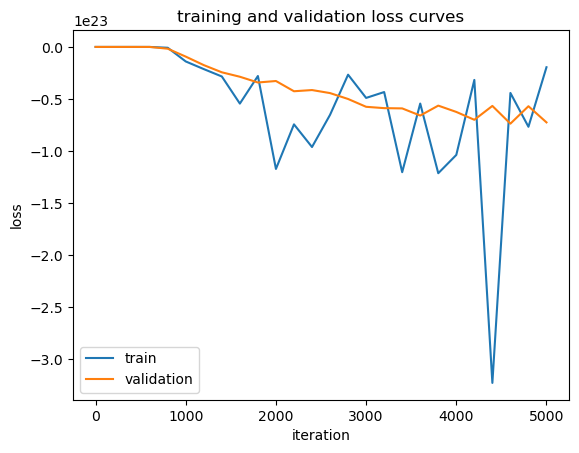

Experiment batch_512: best train loss -3.225012561065264e+23; best val loss -3.225012561065264e+23; last train loss -1.949667050663825e+22; last val loss -1.949667050663825e+22
Experiment setup: {'batch_size': 2048, 'LR': 0.001, 'K': 10, 'name': 'batch_2048'}
[Iteration 0/5000] train_loss: -0.60611, val_loss: -0.18911, val_recall@10: 0.00229, val_precision@10: 0.00127, val_ndcg@10: 0.00159
[Iteration 200/5000] train_loss: -1098421305344.0, val_loss: -478404476928.0, val_recall@10: 0.00592, val_precision@10: 0.00344, val_ndcg@10: 0.00579
[Iteration 400/5000] train_loss: -3.308676228826792e+18, val_loss: -3.7676648839407206e+17, val_recall@10: 0.01155, val_precision@10: 0.00796, val_ndcg@10: 0.01151
[Iteration 600/5000] train_loss: -2.0556083772182002e+21, val_loss: -1.8557412997677764e+21, val_recall@10: 0.02214, val_precision@10: 0.01212, val_ndcg@10: 0.01884
[Iteration 800/5000] train_loss: -2.2160065549267955e+22, val_loss: -1.8216102351892933e+22, val_recall@10: 0.02442, val_precisi

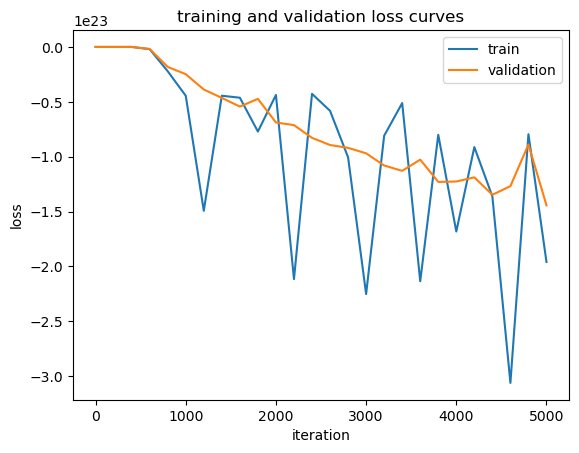

Experiment batch_2048: best train loss -3.061158996542569e+23; best val loss -3.061158996542569e+23; last train loss -1.959394780822949e+23; last val loss -1.959394780822949e+23
Experiment setup: {'batch_size': 1024, 'LR': 0.01, 'K': 10, 'name': 'LR_1e-2'}
[Iteration 0/5000] train_loss: -0.99124, val_loss: -3.90769, val_recall@10: 0.00019, val_precision@10: 0.00054, val_ndcg@10: 0.00046
[Iteration 200/5000] train_loss: -1.413277661512882e+23, val_loss: -8.712002710685664e+22, val_recall@10: 0.03092, val_precision@10: 0.01808, val_ndcg@10: 0.02733
[Iteration 400/5000] train_loss: -4.095162412556743e+23, val_loss: -3.012754307747591e+23, val_recall@10: 0.015, val_precision@10: 0.01302, val_ndcg@10: 0.0183
[Iteration 600/5000] train_loss: -2.3425356368177323e+23, val_loss: -6.366001644026662e+23, val_recall@10: 0.01637, val_precision@10: 0.0123, val_ndcg@10: 0.01731
[Iteration 800/5000] train_loss: -2.0299795176387416e+23, val_loss: -1.0272372799916063e+24, val_recall@10: 0.01629, val_pre

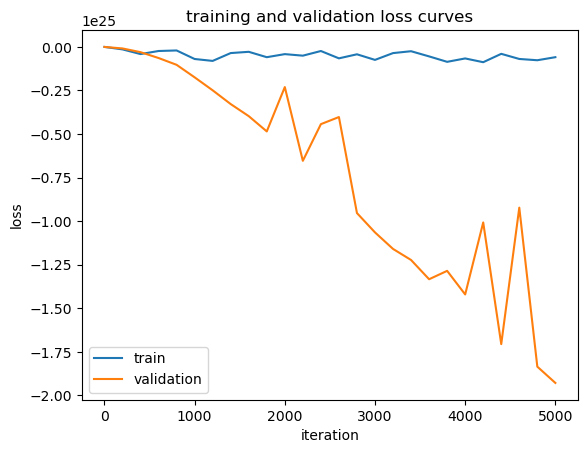

Experiment LR_1e-2: best train loss -8.76659822767241e+23; best val loss -8.76659822767241e+23; last train loss -5.88991279676243e+23; last val loss -5.88991279676243e+23
Experiment setup: {'batch_size': 1024, 'LR': 0.001, 'K': 10, 'name': 'LR_1e-3'}
[Iteration 0/5000] train_loss: -0.98129, val_loss: -0.45998, val_recall@10: 0.00042, val_precision@10: 0.0009, val_ndcg@10: 0.00071
[Iteration 200/5000] train_loss: -74042687488.0, val_loss: -43830788096.0, val_recall@10: 0.00297, val_precision@10: 0.00181, val_ndcg@10: 0.00241
[Iteration 400/5000] train_loss: -7.450809621859533e+16, val_loss: -4.554257907633357e+16, val_recall@10: 0.01105, val_precision@10: 0.0094, val_ndcg@10: 0.01051
[Iteration 600/5000] train_loss: -4.605196612839324e+20, val_loss: -1.810958630973111e+20, val_recall@10: 0.01938, val_precision@10: 0.01356, val_ndcg@10: 0.01618
[Iteration 800/5000] train_loss: -6.235499396472467e+21, val_loss: -5.441783872244784e+21, val_recall@10: 0.01791, val_precision@10: 0.0123, val_

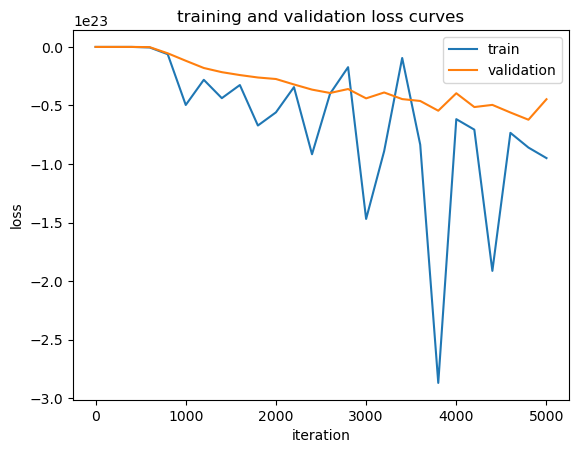

Experiment LR_1e-3: best train loss -2.8683130590587134e+23; best val loss -2.8683130590587134e+23; last train loss -9.491347023322426e+22; last val loss -9.491347023322426e+22
Experiment setup: {'batch_size': 1024, 'LR': 0.0001, 'K': 10, 'name': 'LR_1e-4'}
[Iteration 0/5000] train_loss: -1.41177, val_loss: -0.74829, val_recall@10: 0.00153, val_precision@10: 0.00108, val_ndcg@10: 0.00117
[Iteration 200/5000] train_loss: -96.5496, val_loss: -142.34026, val_recall@10: 0.00153, val_precision@10: 0.00108, val_ndcg@10: 0.0013
[Iteration 400/5000] train_loss: -11918.20898, val_loss: -13542.94336, val_recall@10: 0.00161, val_precision@10: 0.00145, val_ndcg@10: 0.00158
[Iteration 600/5000] train_loss: -230226.73438, val_loss: -416866.1875, val_recall@10: 0.00173, val_precision@10: 0.00181, val_ndcg@10: 0.00221
[Iteration 800/5000] train_loss: -3675727.75, val_loss: -5733159.5, val_recall@10: 0.00177, val_precision@10: 0.00199, val_ndcg@10: 0.00247
[Iteration 1000/5000] train_loss: -71135624.0,

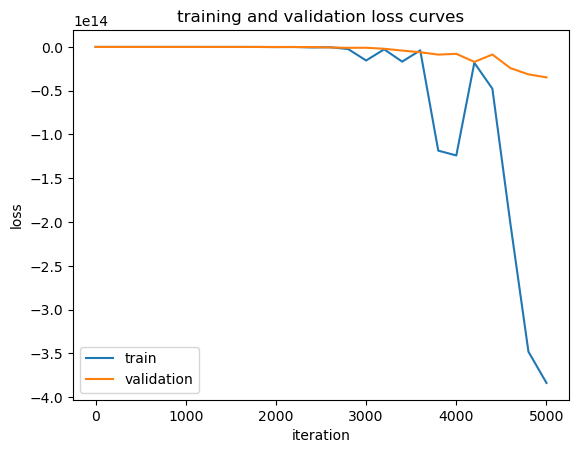

Experiment LR_1e-4: best train loss -383707579940864.0; best val loss -383707579940864.0; last train loss -383707579940864.0; last val loss -383707579940864.0
Experiment setup: {'batch_size': 1024, 'LR': 0.001, 'K': 10, 'name': 'K_10'}
[Iteration 0/5000] train_loss: -1.09733, val_loss: -0.7409, val_recall@10: 0.00071, val_precision@10: 0.00072, val_ndcg@10: 0.00109
[Iteration 200/5000] train_loss: -1512205713408.0, val_loss: -163287810048.0, val_recall@10: 0.00281, val_precision@10: 0.00271, val_ndcg@10: 0.00347
[Iteration 400/5000] train_loss: -1.567788819682427e+17, val_loss: -8.432426115347251e+16, val_recall@10: 0.01084, val_precision@10: 0.00868, val_ndcg@10: 0.01069
[Iteration 600/5000] train_loss: -2.8912726098062816e+20, val_loss: -3.583127899093168e+20, val_recall@10: 0.00962, val_precision@10: 0.0094, val_ndcg@10: 0.01174
[Iteration 800/5000] train_loss: -3.3411786800696364e+22, val_loss: -1.6850475836885378e+22, val_recall@10: 0.01114, val_precision@10: 0.01103, val_ndcg@10:

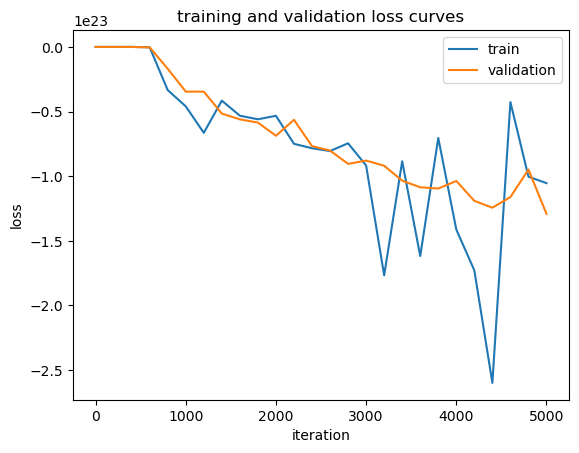

Experiment K_10: best train loss -2.5992237018992666e+23; best val loss -2.5992237018992666e+23; last train loss -1.053653251692339e+23; last val loss -1.053653251692339e+23
Experiment setup: {'batch_size': 1024, 'LR': 0.001, 'K': 50, 'name': 'K_50'}
[Iteration 0/5000] train_loss: -1.66196, val_loss: -1.61597, val_recall@10: 0.00648, val_precision@10: 0.00076, val_ndcg@10: 0.00263
[Iteration 200/5000] train_loss: -94976393216.0, val_loss: -77065592832.0, val_recall@10: 0.01102, val_precision@10: 0.00221, val_ndcg@10: 0.00608
[Iteration 400/5000] train_loss: -8.18064654252114e+16, val_loss: -8.631075224734925e+16, val_recall@10: 0.04519, val_precision@10: 0.00763, val_ndcg@10: 0.02219
[Iteration 600/5000] train_loss: -1.3832554335364322e+21, val_loss: -4.107302211566541e+20, val_recall@10: 0.07932, val_precision@10: 0.0119, val_ndcg@10: 0.03671
[Iteration 800/5000] train_loss: -1.0687965153673798e+22, val_loss: -1.2113969177085696e+22, val_recall@10: 0.07918, val_precision@10: 0.0119, v

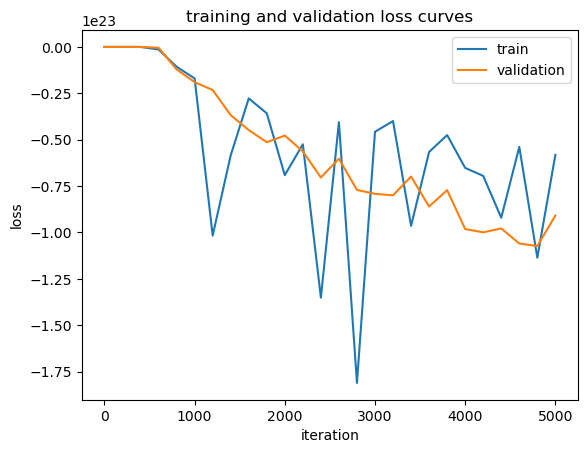

Experiment K_50: best train loss -1.8111308767703593e+23; best val loss -1.8111308767703593e+23; last train loss -5.8177554029567596e+22; last val loss -5.8177554029567596e+22
Experiment setup: {'batch_size': 1024, 'LR': 0.001, 'K': 100, 'name': 'K_100'}
[Iteration 0/5000] train_loss: -1.08142, val_loss: -0.56284, val_recall@10: 0.01036, val_precision@10: 0.0009, val_ndcg@10: 0.00399
[Iteration 200/5000] train_loss: -60985262080.0, val_loss: -47367217152.0, val_recall@10: 0.01979, val_precision@10: 0.00172, val_ndcg@10: 0.00871
[Iteration 400/5000] train_loss: -2.060612350980915e+16, val_loss: -2.090006033412915e+16, val_recall@10: 0.06203, val_precision@10: 0.00483, val_ndcg@10: 0.02617
[Iteration 600/5000] train_loss: -1.445788477312425e+20, val_loss: -1.2696117940534116e+20, val_recall@10: 0.11343, val_precision@10: 0.00841, val_ndcg@10: 0.04384
[Iteration 800/5000] train_loss: -1.109847839280778e+22, val_loss: -7.86819387298272e+21, val_recall@10: 0.12982, val_precision@10: 0.00962

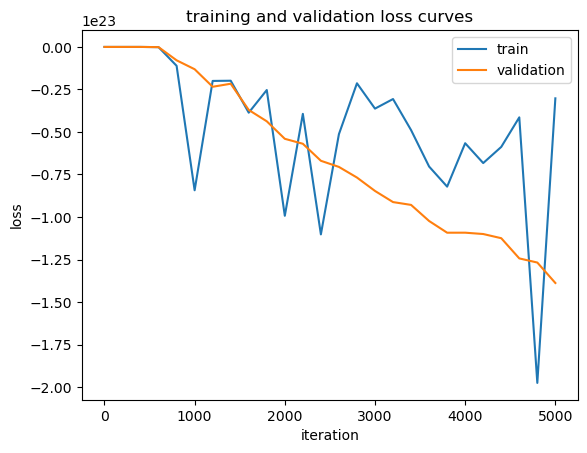

Experiment K_100: best train loss -1.9756743927559678e+23; best val loss -1.9756743927559678e+23; last train loss -3.023064218230545e+22; last val loss -3.023064218230545e+22


In [51]:
best_train_loss = []
best_val_loss = []
last_train_loss = []
last_val_loss = []

experiment_logger(f"Using device {device}.")

for experiment in experiments:

    experiment_logger(f"Experiment setup: {experiments[experiment]}")

    model = None
    model = NGCF(num_users, num_movies)
    model = model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=experiments[experiment]["LR"])
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    edge_index = edge_index.to(device)
    train_edge_index = train_edge_index.to(device)
    train_sparse_edge_index = train_sparse_edge_index.to(device)

    val_edge_index = val_edge_index.to(device)
    val_sparse_edge_index = val_sparse_edge_index.to(device)

    train_losses, val_losses = train(experiments[experiment], optimizer, scheduler)
    draw_graph(experiments[experiment], train_losses, val_losses)

    best_exp_train_loss = train_losses[torch.argmin(torch.tensor(train_losses))]
    best_exp_val_loss = train_losses[torch.argmin(torch.tensor(train_losses))]
    last_exp_train_loss = train_losses[-1]
    last_exp_val_loss = train_losses[-1]

    experiment_logger(f"Experiment {experiment}: best train loss {best_exp_train_loss}; best val loss {best_exp_val_loss}; last train loss {last_exp_train_loss}; last val loss {last_exp_val_loss}")

    best_train_loss.append(best_exp_train_loss)
    best_val_loss.append(best_exp_val_loss)
    last_train_loss.append(last_exp_train_loss)
    last_val_loss.append(last_exp_val_loss)

In [50]:
torch.argmax(torch.tensor([1,2,3]))

tensor(2)